/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.77378094 0.77378094]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


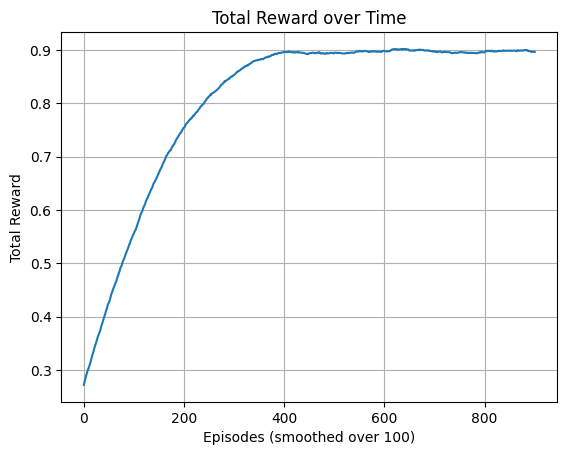

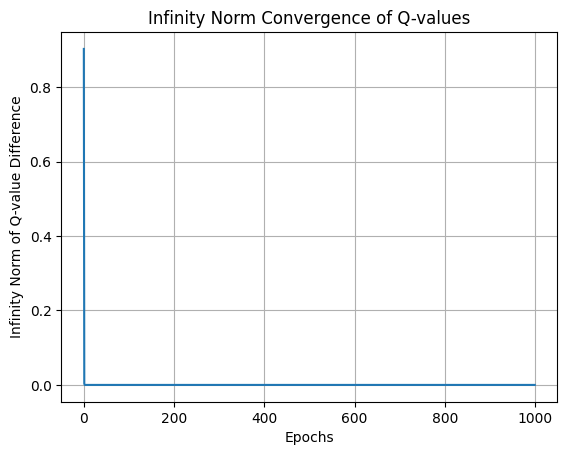

In [20]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Define the moving_average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1', is_slippery=False)  # Deterministic environment for clarity
n_states = env.observation_space.n  # Number of states in the environment
n_actions = env.action_space.n  # Number of possible actions

# Initialize Q-table with zeros
Q_table = np.zeros((n_states, n_actions))

# Define parameters
learning_rate = 0.8
discount_factor = 0.95
initial_zeta = 0.8  # Initial exploration probability
min_zeta = 0.1  # Minimum exploration probability
decay_rate = 0.995  # Exploration decay rate
epochs = 1000
iterations_per_epoch = 100  # Fixed number of iterations per epoch
adversary_strength = 0.2  # Strength of adversarial reward perturbation

# Store Q-tables and rewards over time
Q_tables_over_time = []
rewards = []

# Q-learning algorithm with adversarial rewards
zeta = initial_zeta  # Start with initial exploration probability
for epoch in range(epochs):
    total_rewards = 0
    for _ in range(iterations_per_epoch):
        current_state = env.reset()
        if isinstance(current_state, tuple):  # Handle environments that return state info as a tuple
            current_state = current_state[0]
        done = False
        while not done:
            # Choose action using zeta-greedy strategy
            if np.random.rand() < zeta:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(Q_table[current_state, :])  # Exploit: action with max Q-value

            # Take action and observe next state and reward
            next_state, reward, done, truncated = env.step(action)
            if isinstance(next_state, tuple):  # Handle environments that return state info as a tuple
                next_state = next_state[0]

            # Update Q-value using the Q-learning update rule
            Q_table[current_state, action] += learning_rate * (
                reward
                + discount_factor * np.max(Q_table[next_state, :])
                - Q_table[current_state, action]
            )

            # Move to the next state
            current_state = next_state
            total_rewards += reward

    # Decay the exploration probability after each epoch
    zeta = max(min_zeta, zeta * decay_rate)
    rewards.append(total_rewards / iterations_per_epoch)

    # Store the Q-table at this epoch
    Q_tables_over_time.append(Q_table.copy())

# Calculate the infinity norm of the difference between optimal Q and Q(s, a) over time
optimal_Q_without_corruption = Q_table  # Assume the final Q_table is the optimal Q
infinity_norms = [np.max(np.abs(optimal_Q_without_corruption - Q)) for Q in Q_tables_over_time]
print(optimal_Q_without_corruption)
# Plotting the smoothed rewards
smoothed_rewards = moving_average(rewards, 100)
plt.figure()
plt.plot(smoothed_rewards)
plt.xlabel('Episodes (smoothed over 100)')
plt.ylabel('Total Reward')
plt.title('Total Reward over Time')
plt.grid()
plt.show()

# Plot the infinity norm over epochs
plt.figure()
plt.plot(infinity_norms)
plt.xlabel('Epochs')
plt.ylabel('Infinity Norm of Q-value Difference')
plt.title('Infinity Norm Convergence of Q-values')
plt.grid()
plt.show()


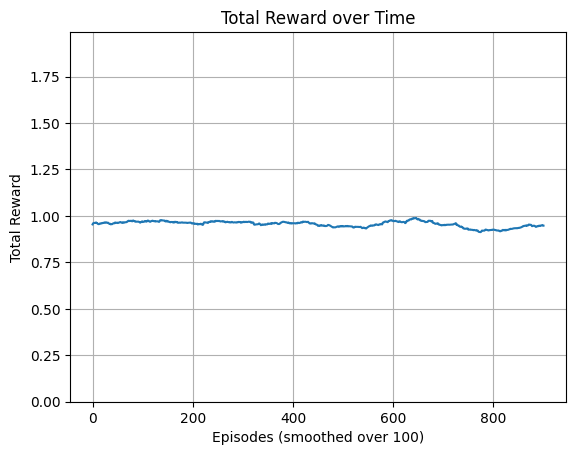

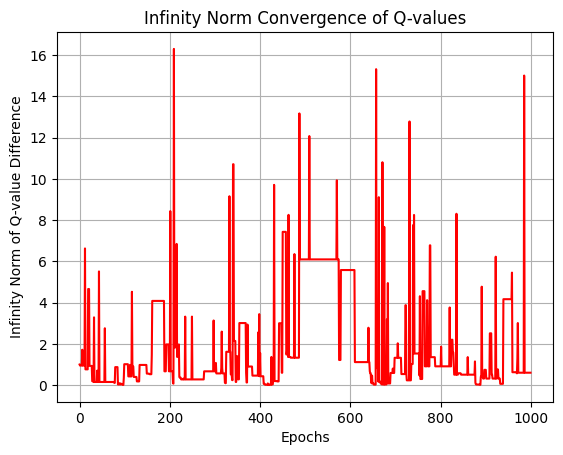

In [21]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1', is_slippery=False)  # Use is_slippery=False for a deterministic environment
n_states = env.observation_space.n  # Number of states in the FrozenLake environment
n_actions = env.action_space.n  # Number of possible actions

# Initialize Q-table with zeros
Q_corrupt_table = np.zeros((n_states, n_actions))

# Define parameters
# Define parameters
learning_rate = 0.8
discount_factor = 0.95
initial_zeta = 0.8  # Start with exploration probability of 0.8
min_zeta = 0.1      # Minimum exploration probability
decay_rate = 0.995  # Rate at which exploration probability decays
epsilon = 0.001  # Probability of reward corruption
corruption_scale = 1  # Scale for the normal distribution
epochs = 1000
iterations_per_epoch = 100  # Fixed number of iterations per epoch
rewards_corruptive=[]
# Function to calculate rewards based on state and action
def calculate_reward(reward):
    # Corrupt the reward with a normal distribution with mean 0 and std deviation scaled by corruption_scale
    if np.random.uniform(0,1) < epsilon:
        corruption = 10*np.random.normal(1, corruption_scale)
        return reward + corruption  # Corrupted reward
    return reward  # Return the original reward

# Store Q-tables at each iteration
Q_tables_over_time_corruptive = []

# Q-learning algorithm
for epoch in range(epochs):
    total_rewards_corruptive=0
    for _ in range(iterations_per_epoch):
        current_state = env.reset()  # Reset environment to start state

        # Ensure that the current state is an integer
        if isinstance(current_state, tuple):
            current_state = current_state[0]

        done = False
        while not done:  # Until we reach a terminal state (hole or goal)
            # Choose action with epsilon-greedy strategy
            if np.random.rand() < zeta:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(Q_corrupt_table[current_state, :])  # Exploit: action with max Q-value

            # Take action, observe next state and reward
            next_state, reward, done, truncated = env.step(action)

            # Ensure that next_state is an integer
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # Calculate reward (corrupted reward)
            corrupted_reward = calculate_reward(reward)

            # Update Q-value using the Q-learning update rule
            Q_corrupt_table[current_state, action] += learning_rate * \
                (corrupted_reward + discount_factor * np.max(Q_corrupt_table[next_state, :]) - Q_corrupt_table[current_state, action])

            # Move to the next state
            current_state = next_state
            total_rewards_corruptive += corrupted_reward
            # Decay the exploration probability after each epoch
    zeta = max(min_zeta, zeta * decay_rate)
    rewards_corruptive.append(total_rewards_corruptive/iterations_per_epoch)
    smoothed_rewards = moving_average(rewards_corruptive, 100)
    # Store the Q-table at this epoch
    Q_tables_over_time_corruptive.append(Q_corrupt_table.copy())

# After training, the Q-table represents the learned Q-values
#print("Learned Q-table:")
#print(Q_corrupt_table)


infinity_norms = [np.max(np.abs( optimal_Q_without_corruption- Q)) for Q in Q_tables_over_time_corruptive]

# Plotting the smoothed rewards
plt.plot(smoothed_rewards)
plt.xlabel('Episodes (smoothed over 100)')
plt.ylabel('Total Reward')
plt.title('Total Reward over Time')
plt.ylim(0, max(smoothed_rewards) + 1)  # Adjusting the y-axis for better visualization
plt.grid()
plt.show()

# Plot the infinity norm over epochs
plt.plot(infinity_norms,color='red')
plt.xlabel('Epochs')
plt.ylabel('Infinity Norm of Q-value Difference')
plt.title('Infinity Norm Convergence of Q-values')
plt.grid()
plt.show()

In [22]:
def univariate_trimmed_mean(Z, Z_tilde, epsilon, delta):
    M = len(Z) + len(Z_tilde)
    assert len(Z) == len(Z_tilde) == M // 2, "Z and Z_tilde must both have M/2 elements."

    # Step 1: Set ζ = 8ε + 24 log(4/δ) / M
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M
    zeta = min(zeta, 1)  # Ensure ζ does not exceed 1

    # Step 2: Compute quantiles γ and β
    Z_sorted = np.sort(Z)
    gamma_index = int(np.floor(zeta * (M // 2)))
    beta_index = int(np.floor((1 - zeta) * (M // 2)))

    gamma_index = min(gamma_index, len(Z_sorted) - 1)  # Ensure the index is within bounds
    beta_index = min(beta_index, len(Z_sorted) - 1)    # Ensure the index is within bounds

    gamma = Z_sorted[gamma_index]
    beta = Z_sorted[beta_index]

    # Step 3: Compute robust mean estimate
    def phi_gamma_beta(x, gamma, beta):
        if x > beta:
            return beta
        elif x < gamma:
            return gamma
        else:
            return x

    trimmed_sum = sum(phi_gamma_beta(x, gamma, beta) for x in Z_tilde)
    hat_mu_T = (2 / M) * trimmed_sum

    return hat_mu_T

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Learned Q-table:
[[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.77378094 0.77378094]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


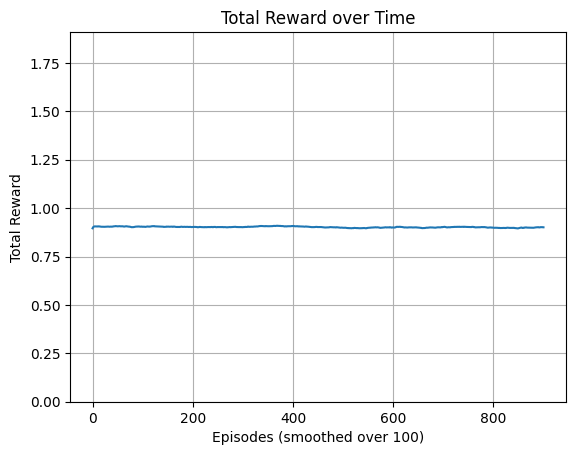

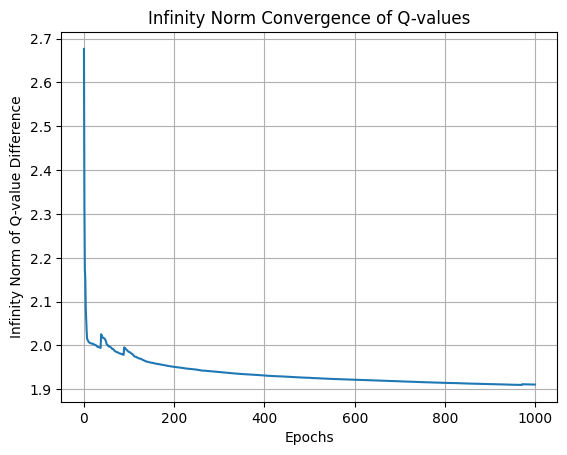

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gym

# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1', is_slippery=False)  # Use is_slippery=False for a deterministic environment
n_states = env.observation_space.n  # Number of states in the FrozenLake environment
n_actions = env.action_space.n  # Number of possible actions

# Initialize Q-table with zeros
Q_table_robust = np.zeros((n_states, n_actions))

# Define parameters
delta = 0.1
learning_rate = 0.8
discount_factor = 0.95
initial_zeta = 0.8  # Start with exploration probability of 0.8
min_zeta = 0.1      # Minimum exploration probability
decay_rate = 0.995  # Rate at which exploration probability decays
epsilon = 0.001  # Probability of reward corruption
corruption_scale = 1  # Scale for the normal distribution
epochs = 1000
iterations_per_epoch = 100  # Fixed number of iterations per epoch
robust_rewards = []
total_iterations = epochs * iterations_per_epoch

# Function to calculate rewards based on state and action
def calculate_reward(reward):
    # Corrupt the reward with a normal distribution with mean 0 and std deviation scaled by corruption_scale
    if np.random.rand() < epsilon:
        corruption = 10 * np.random.normal(1, corruption_scale)
        return reward + corruption  # Corrupted reward
    return reward  # Return the original reward


# Threshold function G_t
def compute_G_t(t, R, C, epsilon, delta_1):
    T_lim = 2 * np.log(4 / delta_1) + 1
    if t <= T_lim:
        return 2 * R
    else:
        return C * R * (np.sqrt(np.log(4 / delta_1) / t) + np.sqrt(epsilon)) + R

# Epsilon-Robust Q-Learning
Q_tables_over_time_robust = []
delta_1 = delta / (2 * n_states * n_actions * total_iterations)
R = 1  # Example R value, adjust as needed
C = 1  # Example C value, adjust as needed

for epoch in range(epochs):
    total_rewards_robust = 0
    past_rewards_dict = {(s, a): [] for s in range(n_states) for a in range(n_actions)}  # Store past rewards for each state-action pair

    for t in range(1, iterations_per_epoch + 1):
        current_state = env.reset()  # Reset environment to start state
        # Ensure that the current state is an integer
        if isinstance(current_state, tuple):
            current_state = current_state[0]

        done = False
        while not done:  # Until we reach a terminal state (hole or goal)
            # Choose action with epsilon-greedy strategy
            if np.random.rand() < initial_zeta:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(Q_table[current_state, :])  # Exploit: action with max Q-value

            # Simulate the environment (move to the next state)
            next_state, reward, done, truncated = env.step(action)

            # Ensure that next_state is an integer
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # Calculate reward
            reward = calculate_reward(reward)

            # Append reward to past rewards for the current state-action pair
            past_rewards = past_rewards_dict[(current_state, action)]
            if len(past_rewards) < 2:  # If not enough data for trimming, use the current reward
                trimmed_reward = reward
            else:
                # Ensure Z and Z_tilde have equal lengths
                midpoint = len(past_rewards) // 2
                Z = past_rewards[:midpoint]
                Z_tilde = past_rewards[midpoint : midpoint * 2]  # Ensure Z_tilde has the same length as Z
                trimmed_reward = univariate_trimmed_mean(Z, Z_tilde, epsilon, delta_1)

            # Apply thresholding
            G_t = compute_G_t(t, R, C, epsilon, delta_1)
            if abs(trimmed_reward) > G_t:
                trimmed_reward = np.sign(trimmed_reward) * G_t

            # Update Q-value using the Q-learning update rule
            Q_table_robust[current_state - 1, action] += (learning_rate / (epoch + 1)) * \
                (trimmed_reward + discount_factor *
                 np.max(Q_table_robust[next_state - 1]) - Q_table_robust[current_state - 1, action])

            # Move to the next state
            current_state = next_state
            total_rewards_robust += trimmed_reward

        # Decay the exploration probability after each epoch
        initial_zeta = max(min_zeta, initial_zeta * decay_rate)
    robust_rewards.append(total_rewards_robust / iterations_per_epoch)

    # Store the Q-table at this epoch
    Q_tables_over_time_robust.append(Q_table_robust.copy())

# After training, the Q-table represents the learned Q-values
print("Learned Q-table:")
print(Q_table)

# Plotting the smoothed rewards
smoothed_rewards = np.convolve(robust_rewards, np.ones(100) / 100, mode='valid')
plt.plot(smoothed_rewards)
plt.xlabel('Episodes (smoothed over 100)')
plt.ylabel('Total Reward')
plt.title('Total Reward over Time')
plt.ylim(0, max(smoothed_rewards) + 1)  # Adjusting the y-axis for better visualization
plt.grid()
plt.show()


infinity_norms = [np.max(np.abs(optimal_Q_without_corruption - Q)) for Q in Q_tables_over_time_robust]

# Plot the infinity norm over epochs
plt.plot(infinity_norms)
plt.xlabel('Epochs')
plt.ylabel('Infinity Norm of Q-value Difference')
plt.title('Infinity Norm Convergence of Q-values')
plt.grid()
plt.show()